In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh
from pygimli.viewer import showMesh
from pygimli.physics.gravimetry import GravityModelling2D, MagneticsModelling
from shapely.geometry import Polygon

import itertools
import mpl_axes_aligner

# Defining the area (for later use in magnetic anomaly calculation)

In [2]:
P1 = [149007.5694,744637.9853] #P
P2 = [176972.2456,715047.2193] #P'

Pdx = P2[0]-P1[0]
Pdy = P2[1]-P1[1]
Ptheta = np.arctan(abs(Pdx/Pdy)) # amount to rotate anticlockwise so model lines up with correct angle, in radians (Aeromagnetic)

# Defining functions to convert image data to polygons to model

In [3]:
def img_to_coords(array, corner_index, depth, width, left_loc):
    """
    array : numpy array
        a two column array acting as a list of values to be converted, including the corners
        array[:,0] contains lengthways coordinates, array[:,1] contains depth coordinates
    corner_index: numpy array
        an array of four indices (top left, top right, bottom left, bottom right) to define where in `array` the corners are
    depth : float
        what the depth of the bottom of the figure is (in desired units for output, e.g. km)
    width : float
        the width of the figure (in desired units for output, e.g. km)
    left_loc : float
        the location of the top left corner (in desired units for output, e.g. km)
    """
    top_left = array[corner_index[0]]
    top_right = array[corner_index[1]]
    bottom_left = array[corner_index[2]]

    zero_depth = top_left[1]

    #shift all depths to be relative to surface
    depths = array[:,1] - zero_depth

    #shift all lateral coordinates to be relative to left edge
    zero_lateral = top_left[0]
    
    lateral = array[:,0] - zero_lateral

    #conversion rate depth-wise
    depth_img = bottom_left[1] - top_left[1]
    depth_conv = depth/depth_img

    #convert all depths to new system

    depths_updated = depths * depth_conv

    #conversion rate lateral-wise
    lateral_img = top_right[0] - top_left[0]
    lateral_conv = width/lateral_img

    lateral_updated = (lateral * lateral_conv) + left_loc

    updated_coords = np.column_stack((lateral_updated,-depths_updated))

    return updated_coords

In [4]:
def extend_polygon(coordinates,distance):
    """ 
    coordinates : numpy array
        A two column array with x and y coordinates for points on the polygons
    distance : float
        Distance to extend the model by left and right
    returns :
        - an array of the new coordinates alongside the indicies of the coordinates 
        which they were extended from and their index in the new coordinate array
        - an array of the old and new coordinates combined
    """
    x = coordinates[:,0]
    y = coordinates[:,1]

    left = np.min(x)
    right = np.max(x)

    new_xs = []
    new_ys = []
    original_indicies = []
    new_indicies = []

    for i in range(len(x)):
        if x[i] == left:
            new_x = x[i]-distance
            new_index = int(len(new_xs)+len(x))
            new_xs.append(new_x)
            new_ys.append(y[i])
            original_indicies.append(int(i))
            new_indicies.append(new_index)
        elif x[i] == right:
            new_x = x[i]+distance
            new_index = int(len(new_xs)+len(x))
            new_xs.append(new_x)
            new_ys.append(y[i])
            original_indicies.append(int(i))
            new_indicies.append(new_index)
            
            
    new_coords = np.column_stack((new_xs,new_ys,original_indicies,new_indicies))
    updated_coords = np.concatenate((coordinates,np.column_stack((new_xs,new_ys))))
    return new_coords,updated_coords

In [5]:
#create a new function to create polygons
def plot_polygons(*args,coordinates):
    """
    *args : (list)
        list of indices for the corresponding coordinates
    coordinates: numpy array
        an array specifying the coordinates of all points in the model (corresponding to indices in *args)
    world: pyGIMLi world
        a world created to plot the polygons within
    Returns the polygons to add to the world to create the geometry
    Note that the first polygon is in region 0
    """
    i = 1
    polygons = []
    for poly in args:
        polyvals = coordinates[poly].tolist() #get coordinates from indices
        polyvals_ed = polyvals
        polyvals_ed.append(polyvals[0])
        centre = Polygon(polyvals_ed).representative_point()
        centre_x = centre.x
        centre_y = centre.y
        new_poly = mt.createPolygon(polyvals,isClosed=True,marker = i,markerPosition=([centre_x,centre_y])) #create polygon
        print("region "+str(i)+' created!')
        i += 1
        polygons.append(new_poly)
    world = mt.mergePLC(polygons)
    
    return world

In [6]:
def SSR_compare_model(model,data):

    """ 
    model : numpy array
        An array containing three columns with data generated from the model
        Column 1 contains distances, column 2 contains data with noise and column 3 contains raw data
    data : numpy array
        An array containing two columns with profile data
        Column 1 contains distances and column 2 contains anomaly data. 
    """
    # get all data points
    data_points = np.union1d(model[:,0], data[:,0])

    # calculating the z-score to remove dimensions from data
    z_model = (model[:,2]-np.mean(model[:,2]))/(np.std(model[:,2],ddof=1)) 

    z_data = (data[:,1]-np.mean(data[:,1]))/(np.std(data[:,1],ddof=1)) 

    # find the anomaly at those data points
    interp_model = np.interp(data_points, model[:,0], z_model)
    interp_data = np.interp(data_points, data[:,0], z_data)

    resid = interp_data - interp_model

    SSR = np.sum(resid**2)
    n_df = len(data_points)

    return SSR, SSR/n_df # returns the sum of the square of the residuals, and that scaled by the number of degrees of freedom

In [7]:
grav_profile_array = np.loadtxt('../../Gravity/grav_profile_array.txt')
rtp_profile_array = np.loadtxt('../../Aeromagnetic/rtp_profile_array.txt')

# Gravity Model 1

In [125]:
points_to_convert = np.loadtxt('Model_1_coords.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([0,35,2,38])
converted_points_grav1 = img_to_coords(points_to_convert,corner_index=corner_indices,depth=15.89e3,width=51.33e3,left_loc=1.367e3)

## Calculating model limits

In [126]:
left = min(converted_points_grav1[:,0])
right = max(converted_points_grav1[:,0])
depth = max(abs(converted_points_grav1[:,1]))

## Defining each polygon geometry

In [127]:
#adding indices of polygon coordinates in numpy array created above
poly1 = [1,3,4,7,8,34,33,37,38,2]
poly8 = [1,3,4,7,9,10,6,5,11,12,0]
poly3 = [33,37,36,32,31,25,26,27,28,30]
poly4 = [36,32,31,35]
poly5 = [7,9,14,13,20,19,30,33,34,8]
poly6 = [5,6,10,11]
poly7 = [9,14,15,10]
poly2 = [10,15,14,13,20,19,18,16,17,12,11]
poly9 = [17,16,18,19,30,28,27,29,21,22,23,24]
poly10 = [21,29,27,26,25,24,23,22]

#corresponding densities
grav1_rho1 = 2800
grav1_rho8 = 2750
grav1_rho3 = 2750
grav1_rho4 = 2500
grav1_rho5 = 3000
grav1_rho6 = 2500
grav1_rho7 = 2900
grav1_rho2 = 2600
grav1_rho9 = 2900
grav1_rho10 = 2600


03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 1367	-7049.47	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 23057.7	-642.948	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 43103	-7577.6	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 52697	-114.812	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 22084.4	-7738.34	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 12119.7	-482.211	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 22779.6	-1951.81	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 1367	-7049.47	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 30681.9	-0	0
03/02/25 - 20:55:54 - Core - WARNING - Duplicated node found for: 35826.5	-1377.75	0


region 1 created!
region 2 created!
region 3 created!
region 4 created!
region 5 created!
region 6 created!
region 7 created!
region 8 created!
region 9 created!
region 10 created!


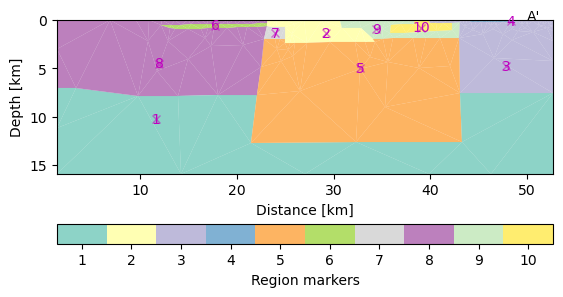

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/55080234.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [129]:
geometry_grav1 = plot_polygons(poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,poly10,
              coordinates=converted_points_grav1)

fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
drawMesh(ax,geometry_grav1)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Model_1_Grav.pdf')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/2610575834.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


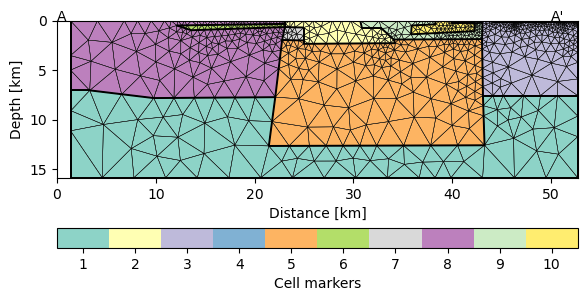

In [130]:
mesh_grav1 = mt.createMesh(geometry_grav1, quality=33,smooth=[2, 4]) #weighted node centre triangles, smoothed with 4 iterations
ax,cb = showMesh(mesh_grav1,markers=True, boundaryMarkers=False,showMesh = True)
ax.set_xlim(left,right)
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
fig.tight_layout()
fig.show()
fig.savefig('Model_1_Grav_Mesh.pdf')

In [131]:
#calculate the densities
dRho_grav1 = pg.solver.parseMapToCellArray([[1, grav1_rho1], [2, grav1_rho2],[3,grav1_rho3],[4,grav1_rho4],[5,grav1_rho5],[6,grav1_rho6],[7,grav1_rho7],[8,grav1_rho8],[9,grav1_rho9],[10,grav1_rho10]], mesh_grav1)
#model along the transect
x_grav1 = np.arange(left, right, .5e3) #measure gravity along 50km profile
pnts_grav1 = np.array([x_grav1, np.zeros(len(x_grav1))]).T #measuring points

fop_grav1 = GravityModelling2D(mesh=mesh_grav1, points=pnts_grav1)
g_grav1 = fop_grav1.response(dRho_grav1) #noise free data

#add some noise (as per https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_03_inv-gravity-2d.html)
error = 0.0005
data_grav1 = g_grav1 + np.random.randn(len(g_grav1)) * error

###
GravModel1 = np.column_stack((x_grav1,data_grav1,g_grav1))
np.savetxt('GravModel1.txt',GravModel1)

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(x_grav1, data_grav1, "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(x_grav1, g_grav1, "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_grav1, dRho_grav1, ax=ax[1])

ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density (kg/m$^3$)')
fig.tight_layout()
fig.savefig('GravModel1_Response.pdf')

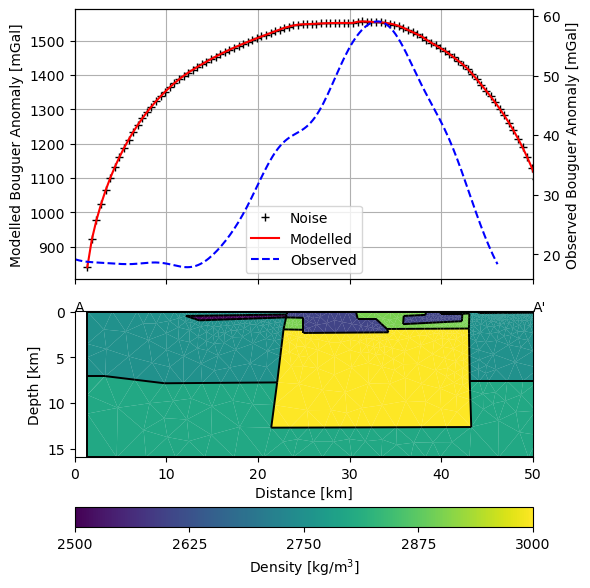

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(x_grav1, data_grav1, "+",c='k', label="Noise")
ln2 = ax[0].plot(x_grav1, g_grav1, "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(grav_profile_array[:,0], grav_profile_array[:,1], "--",c='b', label="Observed")

ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax2.set_ylabel('Observed Bouguer Anomaly [mGal]')
ax[0].grid()
ax[0].legend()

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs,loc=8)

ax1,cb1 = pg.show(mesh_grav1, dRho_grav1, ax=ax[1])

ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density [kg/m$^3$]')
fig.tight_layout()

fig.savefig('GravModel1_final.pdf')

In [114]:
SSR, SSRn_df = SSR_compare_model(GravModel1,grav_profile_array)
print(SSR,'\n', SSRn_df)

192.34984085662353 
 0.6348179566225199


# Gravity Model 2

In [18]:
points_to_convert = np.loadtxt('Model_2_coords.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([0,3,1,2])
converted_points_grav2 = img_to_coords(points_to_convert,corner_index=corner_indices,depth=15.89e3,width=51.33e3,left_loc=1.367e3)

## Setting up the World

In [19]:
left = min(converted_points_grav2[:,0])
right = max(converted_points_grav2[:,0])
depth = max(abs(converted_points_grav2[:,1]))

## Defining each polygon geometry

In [20]:
#adding indices of polygon coordinates in numpy array created above
poly1 = [0,8,36,23,24,37,35,34,33,32,31,13,14,18,17,25,38,5,4,15,16,12,11,10,9]
poly2 = [9,10,11,12,2,1]
poly3 = [31,13,14,26,29,33,32]
poly4 = [26,29,30,34,36,8,7,28,27]
poly5 = [29,30,34,33]
poly6 = [23,36,34,35,37,24]
poly7 = [7,6,22,21,20,19,18,14,26,27,28]
poly8 = [6,5,38,25,17,18,19,20,21,22]
poly9 = [4,3,16,15]

#corresponding densities
grav2_rho1 = 2750
grav2_rho2 = 2800
grav2_rho3 = 3100
grav2_rho4 = 2600
grav2_rho5 = 3100
grav2_rho6 = 2500
grav2_rho7 = 2950
grav2_rho8 = 2600
grav2_rho9 = 2500


03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 1367	-0	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 1367	-7200.78	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 20968	-6557.14	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 34076.1	-2172.3	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 24969.8	-2252.76	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 12229.2	-764.329	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 30605.1	-0	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 38323	-0	0
03/02/25 - 12:47:20 - Core - WARNING - Duplicated node found for: 43958.2	-0	0


region 1 created!
region 2 created!
region 3 created!
region 4 created!
region 5 created!
region 6 created!
region 7 created!
region 8 created!
region 9 created!


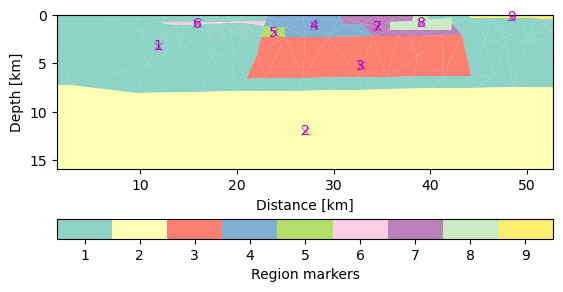

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/2932962809.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [21]:
geometry_grav2 = plot_polygons(poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,
              coordinates=converted_points_grav2)

fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
drawMesh(ax,geometry_grav2)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Model_2_Grav.pdf')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/2473947962.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


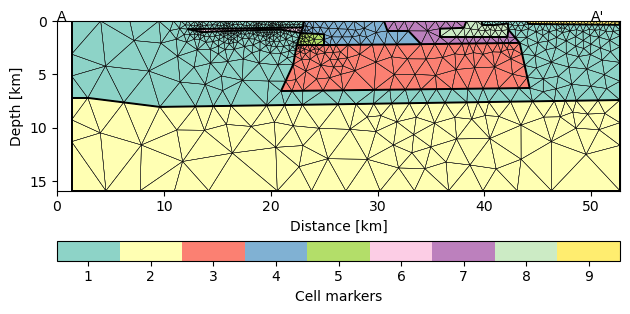

In [22]:
#create mesh
mesh_grav2 = mt.createMesh(geometry_grav2, quality=33,smooth=[2,4])
ax,cb = showMesh(mesh_grav2,markers=True, boundaryMarkers=False,showMesh = True)
fig = ax.get_figure()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
fig.tight_layout()
fig.show()
fig.savefig('Model_2_Grav_Mesh.pdf')

In [23]:
#calculate the densities
dRho_grav2 = pg.solver.parseMapToCellArray([[1, grav2_rho1], [2, grav2_rho2],[3,grav2_rho3],[4,grav2_rho4],[5,grav2_rho5],[6,grav2_rho6],[7,grav2_rho7],[8,grav2_rho8],[9,grav2_rho9]], mesh_grav2)

#model along the transect
x_grav2 = np.arange(left, right, .5e3) #measure gravity along 50m profile
pnts_grav2 = np.array([x_grav2, np.zeros(len(x_grav2))]).T #measuring points

fop_grav2 = GravityModelling2D(mesh=mesh_grav2, points=pnts_grav2)
g_grav2 = fop_grav2.response(dRho_grav2) #noise free data

#add some noise
error = 0.0005
data_grav2 = g_grav2 + np.random.randn(len(g_grav2)) * error

###
GravModel2 = np.column_stack((x_grav2,data_grav2,g_grav2))
np.savetxt('GravModel2.txt',GravModel2)

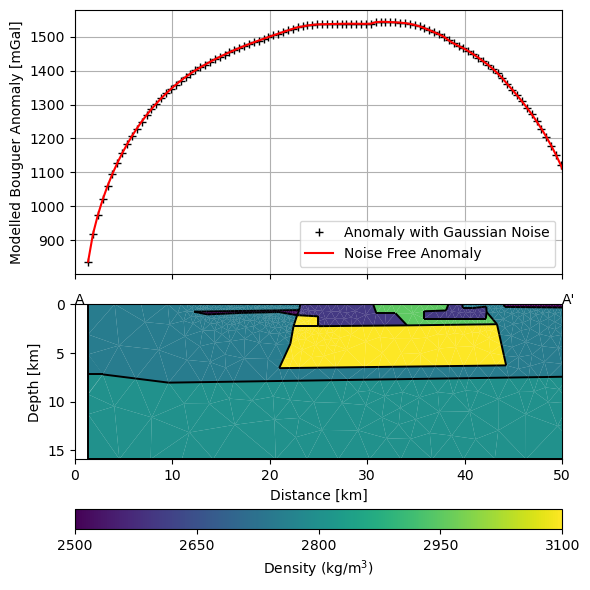

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(x_grav2, data_grav2, "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(x_grav2, g_grav2, "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_grav2, dRho_grav2, ax=ax[1])
#ax[1].plot(x, x*0, 'bv')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density (kg/m$^3$)')
fig.tight_layout()
fig.savefig('GravModel2_Response.pdf')

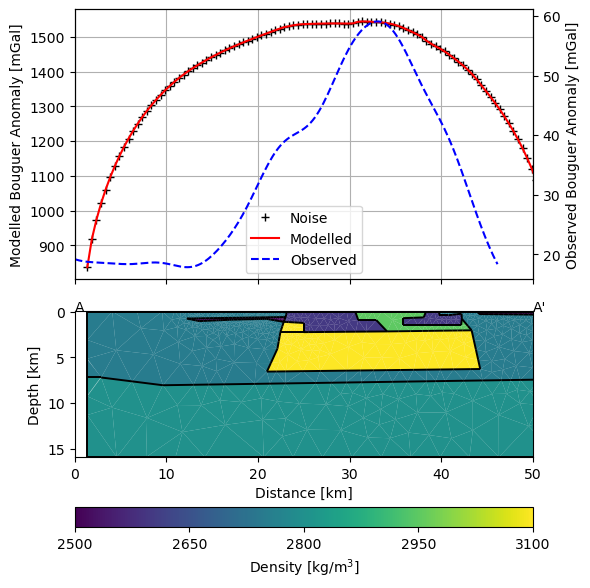

In [25]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(x_grav2, data_grav2, "+",c='k', label="Noise")
ln2 = ax[0].plot(x_grav2, g_grav2, "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(grav_profile_array[:,0], grav_profile_array[:,1], "--",c='b', label="Observed")

ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax2.set_ylabel('Observed Bouguer Anomaly [mGal]')
ax[0].grid()

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs,loc=8)

ax1,cb1 = pg.show(mesh_grav2, dRho_grav2, ax=ax[1])

ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density [kg/m$^3$]')
fig.tight_layout()

fig.savefig('GravModel2_final.pdf')

In [115]:
SSR, SSRn_df = SSR_compare_model(GravModel2,grav_profile_array)
print(SSR,'\n', SSRn_df)

195.95709376395592 
 0.6467230817292274


# Modelling Gravity with $150km$ either side added

## Gravity Model 1

In [28]:
newGravCoords1,updatedGravCoords1 = extend_polygon(converted_points_grav1,150e3)
print(newGravCoords1)

[[-1.48633000e+05 -0.00000000e+00  0.00000000e+00  3.90000000e+01]
 [-1.48633000e+05 -7.04946532e+03  1.00000000e+00  4.00000000e+01]
 [-1.48633000e+05 -1.58900000e+04  2.00000000e+00  4.10000000e+01]
 [ 2.02697000e+05 -0.00000000e+00  3.50000000e+01  4.20000000e+01]
 [ 2.02697000e+05 -1.14812139e+02  3.60000000e+01  4.30000000e+01]
 [ 2.02697000e+05 -7.57760116e+03  3.70000000e+01  4.40000000e+01]
 [ 2.02697000e+05 -1.58900000e+04  3.80000000e+01  4.50000000e+01]]


### Defining each polygon geometry

In [29]:
#adding indices of polygon coordinates in numpy array created above
poly1 = [41,40,1,3,4,7,8,34,33,37,44,45,38,2]
poly8 = [39,40,1,3,4,7,9,10,6,5,11,12,0]
poly3 = [33,37,44,43,42,35,36,32,31,25,26,27,28,30]
poly4 = [36,32,31,35]
poly5 = [7,9,14,13,20,19,30,33,34,8]
poly6 = [5,6,10,11]
poly7 = [9,14,15,10]
poly2 = [10,15,14,13,20,19,18,16,17,12,11]
poly9 = [17,16,18,19,30,28,27,29,21,22,23,24]
poly10 = [21,29,27,26,25,24,23,22]


#corresponding densities
grav1_rho1 = 2800
grav1_rho8 = 2750
grav1_rho3 = 2750
grav1_rho4 = 2500
grav1_rho5 = 3000
grav1_rho6 = 2500
grav1_rho7 = 2900
grav1_rho2 = 2600
grav1_rho9 = 2900
grav1_rho10 = 2600

03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: -148633	-15890	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 23057.7	-642.948	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 43103	-7577.6	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 52697	-114.812	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 22084.4	-7738.34	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 12119.7	-482.211	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 22779.6	-1951.81	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: -148633	-0	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 30681.9	-0	0
03/02/25 - 12:48:35 - Core - WARNING - Duplicated node found for: 35826.5	-1377.75	0


region 1 created!
region 2 created!
region 3 created!
region 4 created!
region 5 created!
region 6 created!
region 7 created!
region 8 created!
region 9 created!
region 10 created!


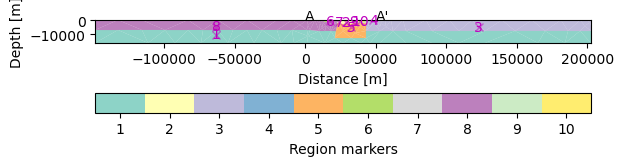

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/2857673610.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [30]:
geometry_grav1_extended = plot_polygons(poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,poly10,
              coordinates=updatedGravCoords1)

fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [m]')
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
drawMesh(ax,geometry_grav1_extended)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Model_1_Grav_extended.pdf')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/3517507872.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


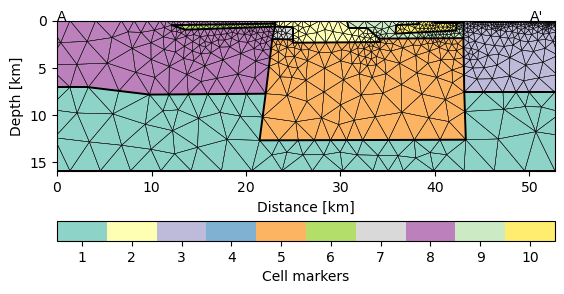

In [31]:
mesh_grav1 = mt.createMesh(geometry_grav1_extended, quality=33,smooth=[2, 4]) #weighted node centre triangles, smoothed with 4 iterations
ax,cb = showMesh(mesh_grav1,markers=True, boundaryMarkers=False,showMesh = True)
ax.set_xlim(left,right)
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
fig.tight_layout()
fig.show()
fig.savefig('Model_1_Grav_Mesh_extended.pdf')

In [32]:
#calculate the densities
dRho_grav1_ext = pg.solver.parseMapToCellArray([[1, grav1_rho1], [2, grav1_rho2],[3,grav1_rho3],[4,grav1_rho4],[5,grav1_rho5],[6,grav1_rho6],[7,grav1_rho7],[8,grav1_rho8],[9,grav1_rho9],[10,grav1_rho10]], mesh_grav1)
#model along the transect
x_grav1 = np.arange(left, right, .5e3) #measure gravity along 50km profile
pnts_grav1 = np.array([x_grav1, np.zeros(len(x_grav1))]).T #measuring points

fop_grav1 = GravityModelling2D(mesh=mesh_grav1, points=pnts_grav1)
g_grav1_ext = fop_grav1.response(dRho_grav1_ext) #noise free data

#add some noise
error = 0.0005
data_grav1_ext = g_grav1_ext + np.random.randn(len(g_grav1_ext)) * error

###
GravModel1_ext = np.column_stack((x_grav1,data_grav1_ext,g_grav1_ext))
np.savetxt('GravModel1_extended.txt',GravModel1_ext)

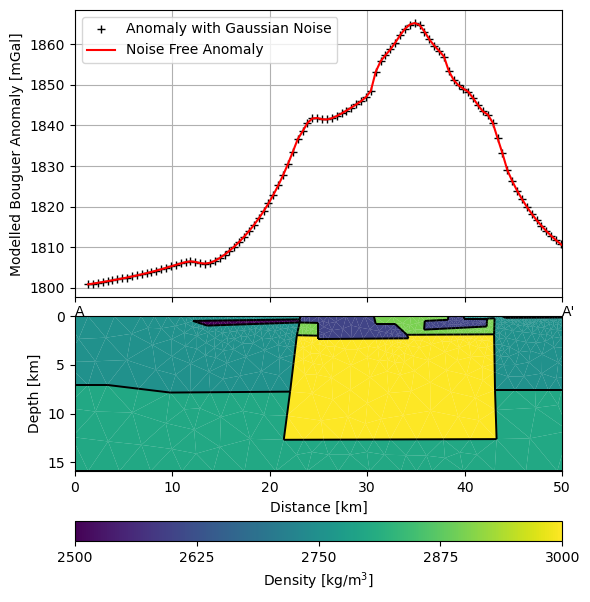

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(x_grav1, data_grav1_ext, "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(x_grav1, g_grav1_ext, "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_grav1, dRho_grav1_ext, ax=ax[1])
#ax[1].plot(x, x*0, 'bv')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density [kg/m$^3$]')
fig.tight_layout()
fig.savefig('GravModel1_Response_ext.pdf')

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(x_grav1, data_grav1_ext, "+",c='k', label="Noise")
ln2 = ax[0].plot(x_grav1, g_grav1_ext, "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(grav_profile_array[:,0], grav_profile_array[:,1], "--",c='b', label="Observed")

ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax2.set_ylabel('Observed Bouguer Anomaly [mGal]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_grav1, dRho_grav1_ext, ax=ax[1])

ax1.grid(alpha=0.3,ls='--')

ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density [kg/m$^3$]')
fig.tight_layout()

fig.savefig('GravModel1_final_extended.pdf')

In [116]:
SSR, SSRn_df = SSR_compare_model(GravModel1_ext,grav_profile_array)
print(SSR,'\n', SSRn_df)

30.964141003359753 
 0.10219188449953714


## Extending Gravity Model 2

In [36]:
newGravCoords2,updatedGravCoords2 = extend_polygon(converted_points_grav2,5*50e3)
print(newGravCoords2)

[[-2.48633000e+05 -0.00000000e+00  0.00000000e+00  3.90000000e+01]
 [-2.48633000e+05 -1.58900000e+04  1.00000000e+00  4.00000000e+01]
 [ 3.02697000e+05 -1.58900000e+04  2.00000000e+00  4.10000000e+01]
 [ 3.02697000e+05 -0.00000000e+00  3.00000000e+00  4.20000000e+01]
 [-2.48633000e+05 -7.20078481e+03  9.00000000e+00  4.30000000e+01]
 [ 3.02697000e+05 -7.40192405e+03  1.20000000e+01  4.40000000e+01]
 [ 3.02697000e+05 -3.62050633e+02  1.60000000e+01  4.50000000e+01]]


In [37]:
#adding indices of polygon coordinates in numpy array created above
poly1 = [0,8,36,23,24,37,35,34,33,32,31,13,14,18,17,25,38,5,4,15,16,3,42,45,44,12,11,10,9,43,39]
poly2 = [9,10,11,12,44,41,2,1,40,43]
poly3 = [31,13,14,26,29,33,32]
poly4 = [26,29,30,34,36,8,7,28,27]
poly5 = [29,30,34,33]
poly6 = [23,36,34,35,37,24]
poly7 = [7,6,22,21,20,19,18,14,26,27,28]
poly8 = [6,5,38,25,17,18,19,20,21,22]
poly9 = [4,3,16,15]

#corresponding densities
grav2_rho1 = 2750
grav2_rho2 = 2800
grav2_rho3 = 3100
grav2_rho4 = 2600
grav2_rho5 = 3100
grav2_rho6 = 2500
grav2_rho7 = 2950
grav2_rho8 = 2600
grav2_rho9 = 2500

03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 1367	-0	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 1367	-7200.78	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 20968	-6557.14	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 34076.1	-2172.3	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 24969.8	-2252.76	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 12229.2	-764.329	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 30605.1	-0	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 38323	-0	0
03/02/25 - 12:50:41 - Core - WARNING - Duplicated node found for: 43958.2	-0	0


region 1 created!
region 2 created!
region 3 created!
region 4 created!
region 5 created!
region 6 created!
region 7 created!
region 8 created!
region 9 created!


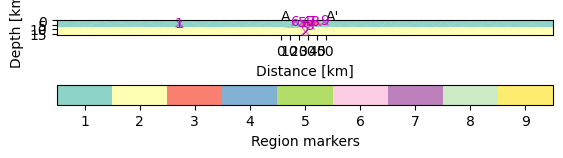

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/3109179137.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [38]:
geometry_grav2_extended = plot_polygons(poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,
              coordinates=updatedGravCoords2)

fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
drawMesh(ax,geometry_grav2_extended)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Model_2_Grav_extended.pdf')

In [39]:
mesh_grav2 = mt.createMesh(geometry_grav2_extended, quality=33,smooth=[2, 4]) #weighted node centre triangles, smoothed with 4 iterations
ax,cb = showMesh(mesh_grav2,markers=True, boundaryMarkers=False,showMesh = True)
ax.set_xlim(left,right)
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax.annotate(text='A',xy=[2,0],zorder=0)
ax.annotate(text='A\'',xy=[50e3,0],zorder=0)
fig.tight_layout()
fig.show()
fig.savefig('Model_2_Grav_Mesh_extended.pdf')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_68427/1044637258.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [40]:
#calculate the densities
dRho_grav2_ext = pg.solver.parseMapToCellArray([[1, grav2_rho1], [2, grav2_rho2],[3,grav2_rho3],[4,grav2_rho4],[5,grav2_rho5],[6,grav2_rho6],[7,grav2_rho7],[8,grav2_rho8],[9,grav2_rho9]], mesh_grav2)

#model along the transect
x_grav2 = np.arange(left, right, .5e3) #measure gravity along 50m profile
pnts_grav2 = np.array([x_grav2, np.zeros(len(x_grav2))]).T #measuring points

fop_grav2 = GravityModelling2D(mesh=mesh_grav2, points=pnts_grav2)
g_grav2_ext = fop_grav2.response(dRho_grav2_ext) #noise free data

#add some noise
error = 0.0005
data_grav2_ext = g_grav2_ext + np.random.randn(len(g_grav2_ext)) * error

###
GravModel2_ext = np.column_stack((x_grav2,data_grav2_ext,g_grav2_ext))
np.savetxt('GravModel2_ext.txt',GravModel2_ext)

In [41]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(x_grav2, data_grav2_ext, "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(x_grav2, g_grav2_ext, "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_grav2, dRho_grav2_ext, ax=ax[1])
#ax[1].plot(x, x*0, 'bv')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density (kg/m$^3$)')
fig.tight_layout()
fig.savefig('GravModel2_Response_ext.pdf')

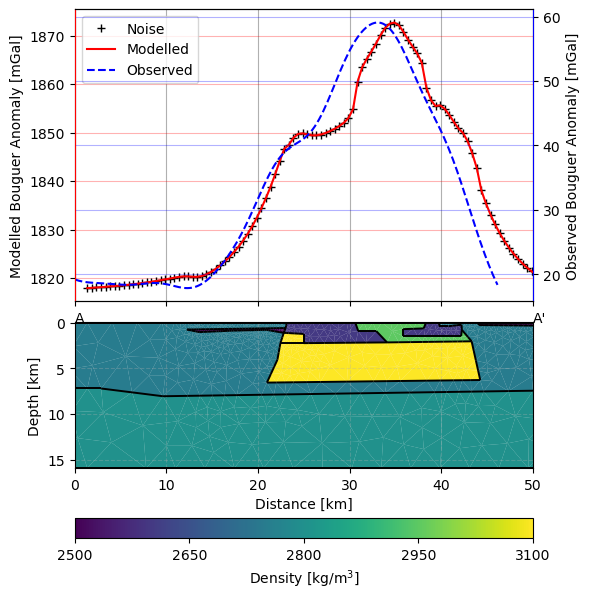

In [42]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(x_grav2, data_grav2_ext, "+",c='k', label="Noise")
ln2 = ax[0].plot(x_grav2, g_grav2_ext, "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(grav_profile_array[:,0], grav_profile_array[:,1], "--",c='b', label="Observed")

ax[0].set_ylabel('Modelled Bouguer Anomaly [mGal]')
ax2.set_ylabel('Observed Bouguer Anomaly [mGal]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_grav2, dRho_grav2_ext, ax=ax[1])

ax1.grid(alpha=0.3,ls='--')

ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth, 1))
ax1.set_xlim((0, 50e3))
ax1.set_xticks(np.arange(0, 60e3, step=10e3), labels=[str(i*10) for i in range(6)])
ax1.set_yticks(np.arange(0, -2e4, step=-0.5e4), labels=[str(i*5) for i in range(4)])
ax1.annotate(text='A',xy=[2,0],zorder=0)
ax1.annotate(text='A\'',xy=[50e3,0],zorder=0)

cb1.set_label(r'Density [kg/m$^3$]')
fig.tight_layout()

fig.savefig('GravModel2_final_extended.pdf')

In [117]:
SSR, SSRn_df = SSR_compare_model(GravModel2_ext,grav_profile_array)
print(SSR,'\n', SSRn_df)

27.460374673596544 
 0.09062829925279388


# 2.5D Modelling of Gravity and Magnetic Anomalies

## Magnetic Model 1

In [97]:
points_to_convert = np.loadtxt('Model_1_coords_MAG.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([7,8,9,10])
converted_points_mag1 = img_to_coords(points_to_convert,corner_index=corner_indices,depth=5.041e3,width=40.8e3,left_loc=0)

### Setting up the World

In [98]:
left_mag1 = min(converted_points_mag1[:,0])
right_mag1 = max(converted_points_mag1[:,0])
depth_mag1 = max(abs(converted_points_mag1[:,1]))

### Defining each polygon geometry

In [99]:
#adding indices of polygon coordinates in numpy array created above
poly1_mag1 = [0,1,2,3,4,5,6]
poly2_mag1 = [7,8,10,9]

#corresponding magnetisations
mag1_rho1 = 6.5
mag1_rho2 = 0

03/02/25 - 20:37:24 - Core - WARNING - Duplicated node found for: 0	-0	0
03/02/25 - 20:37:24 - Core - WARNING - Duplicated node found for: 16809.6	-0	0


region 1 created!
region 2 created!


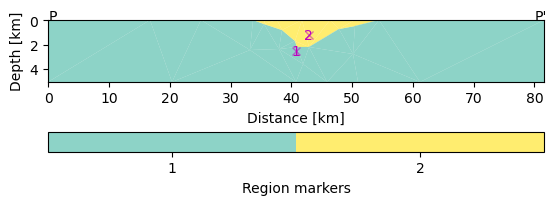

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/2112993957.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [100]:
geometry_mag1 = plot_polygons(poly2_mag1,poly1_mag1,
              coordinates=converted_points_mag1)
fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_ylim(left_mag1,right_mag1)
ax.set_xlim(-depth_mag1,0)
ax.set_xticks(np.arange(0, 50e3, step=5e3), labels=[str(i*10) for i in range(10)])
ax.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax.annotate(text='P',xy=[2,0],zorder=0)
ax.annotate(text='P\'',xy=[40e3,0],zorder=0)
drawMesh(ax,geometry_mag1)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Mag_Model1_2D.pdf')

In [101]:
"""
Function defined with help from Ecosia Chat, using the following prompt:

I have a set of coordinates, `coords` (a list) which denote the edges 
(x,z coordinates) of a polygon with a number of sides. I have a z coordinate, 
`zcoord`, and wish to know the corresponding x coordinates which pertain to the 
lines of the polygon which it passes through. How do I do this using numpy?

"""
def polyinterp(coords, zcoord):

    x_coords = coords[:, 0]  # Extract x coordinates
    z_coords = coords[:, 2]  # Extract z coordinates
    
    intersections = []

    for i in range(len(coords)):

        x1, z1 = x_coords[i], z_coords[i]
        x2, z2 = x_coords[(i + 1) % len(coords)], z_coords[(i + 1) % len(coords)]
    
        if (z1 <= zcoord <= z2) or (z2 <= zcoord <= z1):
            # Using linear interpolation
            if z1 != z2:  # Prevent division by zero
                x_intersect = x1 + (zcoord - z1) * (x2 - x1) / (z2 - z1)
                intersections.append(x_intersect)
    
    return intersections

In [102]:
def polymaker3D(poly,coordinates,zmin,zmax,rot,spacing=50,marker=1,rotate=True,segments=25):
    """
    Parameters
    -----------
    attribute : float
        value to be attributed to the mesh
    poly : list
        of the 2D polygon coordinates (can contain 2 sets)
    coordinates : numpy.ndarray
        a two column numpy array giving the coordinates of the 
        polygon
    angle : float
        the angle which the model should be rotated from north
    d_easting : float
        the change in easting to get the origin to its location in cartesian coordinates
    d_northing : float
        the change in northing to get the origin to its location in cartesian coordinates
    xmin : float
        minimum x for world
    xmax : float
        maximum x for world
    zmin : float
        minimum z for world
    zmax : float
        maximum z for world
    rot : float
        angle, in radians to rotate about the z axis anticlockwise (about the origin)
    trans_x : float
        distance in x to translate the x=0 point
    trans_y : float
        distance in y to translate the y=0 point
    spacing : float, default: 50
        a float which gives the spacing of grid points
    rotate : boolean
        True allows for rotation, False suppresses rotation
    segments : float
        Number of segments to the cylinders produced
    """

    polyvals = coordinates[poly].T
    polyvals_x = polyvals[0]
    polyvals_z = polyvals[1]
    zeros = np.zeros(len(polyvals_x))
    polyvals3D = np.column_stack((polyvals_x,zeros,polyvals_z))
    z_min = np.min(polyvals_z)
    z_max = np.max(polyvals_z)
    
    # defining the z coordinates to be used for cylinders
    grid_floor = np.round(zmin/spacing)*spacing
    grid_ceil = np.round(zmax/spacing)*spacing

    gridz = np.arange(grid_floor,grid_ceil+spacing,spacing)
    
    cylinders = []
    cylinders_rot = []
    x_list = []
    vols = []
    for z in range(len(gridz)):
         z_true = gridz[z]
         if z_true <= z_max and z_true >= z_min:
            x_vals = polyinterp(polyvals3D,z_true)
            if len(x_vals) >=2:
                x_min_cir = np.min(x_vals)
                x_max_cir = np.max(x_vals)
                x_list.append([x_min_cir,x_max_cir])
                r_x = (x_max_cir-x_min_cir)/2
                centre_x = x_min_cir+r_x
                print('z = ',z_true)
                print('Making cylinder')
                cylinder = mt.createCylinder(radius=r_x,
                                             height=spacing,
                                             pos=[centre_x,0,z_true-(spacing/2)],
                                             nSegments=segments,
                                             marker=marker, # defining as a different magnetisation
                                             markerPosition=[centre_x,0,z_true-(spacing/2)]) 
                volume = 2*np.pi*((r_x/1000)**2)*(spacing/1000) # volume of each cylinder, in km3
                print(volume,'km3')

                vols.append(volume)
                # only gets up to surface (cylinder top defined)
                print('Making mesh')
                cylinder_mesh = mt.createMesh(cylinder,
                                              quality = 34)
                #adding marker
                num_cells = cylinder_mesh.cellCount()
                markers = pg.IVector(num_cells)  
                markers.fill(marker)  
                cylinder_mesh.setCellMarkers(markers)

                if rotate is True:
                    print('Rotating mesh')
                    cylinder_mesh_rot = pg.Mesh(cylinder_mesh)
                    cylinder_mesh_rot.rotate([0,0,rot]) 
                    # using a low quality mesh for efficiency
                    cylinders_rot.append(cylinder_mesh_rot)
                cylinders.append(cylinder_mesh)
    worldx_max = np.max(x_list)
    worldx_min = np.min(x_list)
    worldy_max = (worldx_max-worldx_min)/2
    worldy_min = -worldy_max

    total_volume = np.sum(vols)
    print('Total Volume = ',total_volume,' km3')

    vol = mt.createCube(start=[worldx_min,worldy_min,zmin],end=[worldx_max,worldy_max,zmax])
    vol_mesh = mt.createMesh(vol,quality = 34)
    
    if rotate is True:
        return cylinders,cylinders_rot,vol_mesh
    else:
        return cylinders,vol_mesh

In [103]:
mag3D_1_norot,mag3D_1,volmag3D_1 = polymaker3D(poly1_mag1,
                      converted_points_mag1,
                      -depth_mag1,
                      0,
                      Ptheta,
                      spacing=100)

z =  -2100.0
Making cylinder
0.2083235412755614 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp0u8i1sxk.poly.
  Segments are connected properly.
Rotating mesh
z =  -2000.0
Making cylinder
0.2887549920095116 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpl7sbope8.poly.
  Segments are connected properly.
Rotating mesh
z =  -1900.0
Making cylinder
0.3822872418433455 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpsvn_4uu7.poly.
  Segments are connected properly.
Rotating mesh
z =  -1800.0
Making cylinder
0.4889202907770579 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpj5u08bq1.poly.
  Segments are connected properly.
Rotating mesh
z =  -1700.0
Making cylinder
0.6086541388106563 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmplx1q3z0r.poly.
  Segments are connected properly.
Rotating mesh
z =  -1600.0
Making cylinder
0.7876753403809381 km3
Making m

In [104]:
def plot3DMagModel(Model,Volume,Mag):
    """
    Model : pyGIMLi mesh
        3D magnetised mesh
    Volume : pyGIMLi mesh
        3D cubic volume encapsulating the model
    Mag : list
        List of magnetisation of meshes (in A/m) e.g. [1,Magnetisation]
    
    """
    pl, _ = pg.show(Volume,style='wireframe',
                opacity=0, hold=True)
    full = len(Model)
    i=1
    for mesh in Model:
        Amag = pg.solver.parseMapToCellArray([Mag],mesh=mesh)
        pvmesh = pg.viewer.pv.toPVMesh(mesh=mesh,data=Amag,label='Magnetisation [A/m]')
        pl.add_mesh(pvmesh,
                    #color='green',
                    opacity=0.3,
                    style='surface', cmap='coolwarm', clim=[-6.1, 6.1])
        print((i/full)*100,'% Complete')
        i=i+1
    pl.add_axes(interactive=False,xlabel='Distance [m]',zlabel='Depth [m]')
    pl.zoom_camera(10)
    pl.camera_position = 'xz'
    return pl, _

4.545454545454546 % Complete
9.090909090909092 % Complete
13.636363636363635 % Complete
18.181818181818183 % Complete
22.727272727272727 % Complete
27.27272727272727 % Complete
31.818181818181817 % Complete
36.36363636363637 % Complete
40.909090909090914 % Complete
45.45454545454545 % Complete
50.0 % Complete
54.54545454545454 % Complete
59.09090909090909 % Complete
63.63636363636363 % Complete
68.18181818181817 % Complete
72.72727272727273 % Complete
77.27272727272727 % Complete
81.81818181818183 % Complete
86.36363636363636 % Complete
90.9090909090909 % Complete
95.45454545454545 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


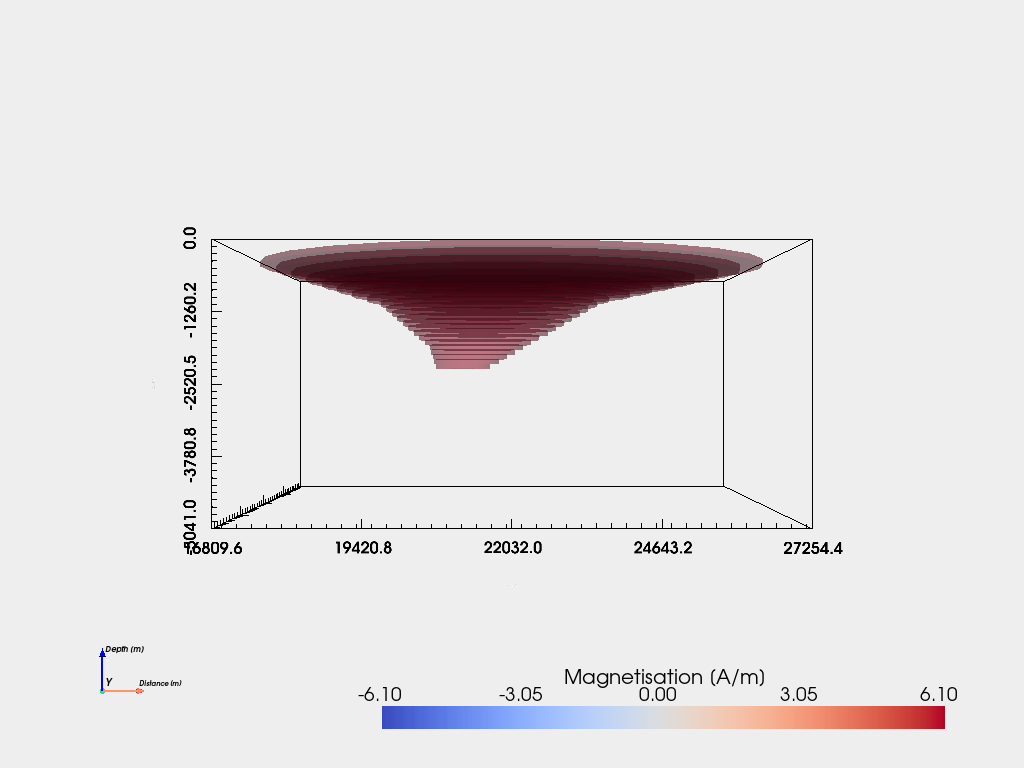

In [105]:
pl,_ = plot3DMagModel(mag3D_1_norot,volmag3D_1,[1,mag1_rho1])
pl.show()
pl.save_graphic('Mag1_Model_3D.pdf')


In [106]:
# calculating field
def igrf_calc(F,I,D):
    '''
    from https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_08_inv-magnetics-3d.html

    F : float
        the value of the total magnetic field anomaly in nT
    I : float
        inclination
    D : float
        declination
    '''
    H = F * np.cos(np.deg2rad(I))
    X = H * np.cos(np.deg2rad(D))
    Y = H * np.sin(np.deg2rad(D))
    Z = F * np.sin(np.deg2rad(I))
    return [D, I, H, X, Y, Z, F]

In [107]:
# from https://stackoverflow.com/a/58781388
# rotate anticlockwise
def rotate(p, origin=(0, 0), angle=0):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

In [108]:
def MagResponse(meshes,left,right,spacing,angle,F,I,D,Mag,cmp=['TFA']):
    """
    meshes : list of pyGIMLi meshes
        List of meshes to have response calculated
    left : float
        Minimum x value of world (where magnetic response will be taken)
    right : float
        Maximum x value of world (where magnetic response will be taken)
    spacing : float
        Spacing of points to measure magnetic response (in metres)
    angle : float
        Angle (in radians) which the mesh was rotated
    F : float
        the value of the total magnetic field anomaly in nT
    I : float
        inclination
    D : float
        declination
    Mag : float
        Magnetisation of mesh (in nT)
    cmp : string
        Forward operator (default: ['TFA'])
    """
    igrf = igrf_calc(F, I, D)

    x = np.arange(left,right,spacing)
    y = np.zeros(len(x))
    z = np.ones_like(x)*1.5e3

    points_mag2D_1 = list(map(lambda a, b:(a,b), x, y))

    rot_points_mag2D_1 = rotate(points_mag2D_1,angle=angle)

    final_points_mag2D_1 = np.column_stack((rot_points_mag2D_1[:,0],rot_points_mag2D_1[:,1],z))

    responses = []
    data = []
    for i in range(len(meshes)):
        mesh = meshes[i]
        fop = MagneticsModelling(mesh=mesh, points=final_points_mag2D_1,cmp=cmp,igrf=igrf)

        dRho_mag13D = pg.solver.parseMapToCellArray([[1, Mag]],mesh=mesh)

        mag3D_1_rep = fop.response(dRho_mag13D)

        noise_level = np.abs(mag3D_1_rep)*0.02+1
        data_mag3D_1 = (np.random.randn(len(mag3D_1_rep)) * noise_level)+mag3D_1_rep

        responses.append(mag3D_1_rep)
        data.append(data_mag3D_1)
    
    OverallResponses = np.sum(responses,axis=0)
    Overalldata = np.sum(data,axis=0)

    ###
    MagModel = np.column_stack((x,Overalldata,OverallResponses))

    return MagModel

In [109]:
MagModel1 = MagResponse(mag3D_1,left_mag1,
                                       right_mag1,
                                       500,
                                       Ptheta,
                                       40801, 
                                       70.25, 
                                       -12.074,
                                       mag1_rho1)

03/02/25 - 20:38:56 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 20:38:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 20:38:56 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 50 Cells: 69 Boundaries: 186
03/02/25 - 20:38:56 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.4s x 7): /Users/george/Library/Caches/pygimli/12890101158493460378
03/02/25 - 20:38:56 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 20:38:56 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 20:38:56 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 50 Cells: 69 Boundaries: 186
03/02/25 - 20:38:56 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.2s x 7): /Users/george/Library/Caches/pygimli/11598489968524106738
03/02/25 - 2

In [58]:
np.savetxt('Mag_Model1.txt',MagModel1)

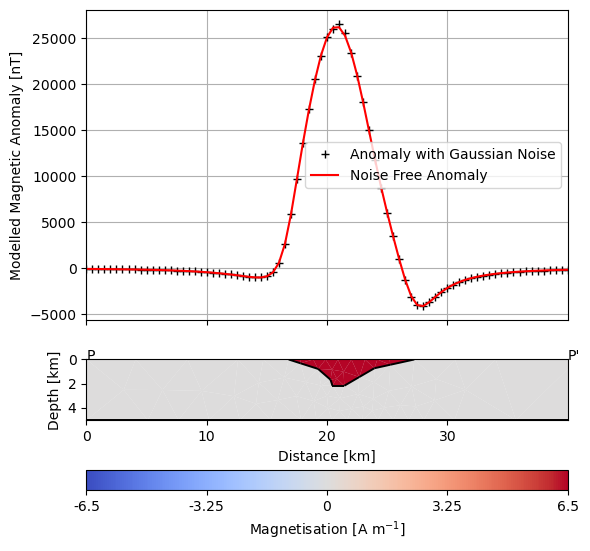

In [133]:
mesh_mag1_2D = mt.createMesh(geometry_mag1, quality=33,smooth=[2,4])
MagAnom1 = pg.solver.parseMapToCellArray([[2, mag1_rho1], [1, mag1_rho2]],mesh_mag1_2D)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(MagModel1[:,0], MagModel1[:,1], "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(MagModel1[:,0], MagModel1[:,2], "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_mag1_2D, MagAnom1, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
#ax[1].plot(x, x*0, 'bv')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag1, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation [$\mathrm{A \ m^{-1}}$]')
fig.tight_layout()
fig.savefig('MagModel1_Response.pdf')

In [134]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(MagModel1[:,0], MagModel1[:,1], "+",c='k', label="Noise")
ln2 = ax[0].plot(MagModel1[:,0], MagModel1[:,2], "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(rtp_profile_array[:,0], rtp_profile_array[:,1], "--",c='b', label="Observed")

mpl_axes_aligner.align.yaxes(ax[0],0,ax2,0,0.3)

ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax2.set_ylabel('Observed Magnetic Anomaly [nT]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_mag1_2D, MagAnom1, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
ax1.grid(alpha=0.3,ls='--')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag1, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation [$\mathrm{A \ m^{-1}}$]')
fig.tight_layout()
fig.savefig('MagModel1_final.pdf')

In [118]:
SSR, SSRn_df = SSR_compare_model(MagModel1,rtp_profile_array)
print(SSR,'\n', SSRn_df)

40.8714756084191 
 0.07034677385270069


## Magnetic Model 2

In [113]:
points_to_convert = np.loadtxt('Model_2_coords_MAG.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([9,10,11,12])
converted_points_mag2 = img_to_coords(points_to_convert,corner_index=corner_indices,depth=5.041e3,width=40.8e3,left_loc=0)

### Setting up the World

In [114]:
left_mag2 = min(converted_points_mag2[:,0])
right_mag2 = max(converted_points_mag2[:,0])
depth_mag2 = max(abs(converted_points_mag2[:,1]))

### Defining each polygon geometry

In [115]:
#adding indices of polygon coordinates in numpy array created above
poly1_mag2 = [0,8,2,3,4,5,6,7,1]
poly2_mag2 = [9,10,12,11]

#corresponding magnetisations
mag2_rho1 = 5.2
mag2_rho2 = 0

03/02/25 - 20:46:59 - Core - WARNING - Duplicated node found for: 0	-0	0
03/02/25 - 20:46:59 - Core - WARNING - Duplicated node found for: 20400	-0	0


region 1 created!
region 2 created!


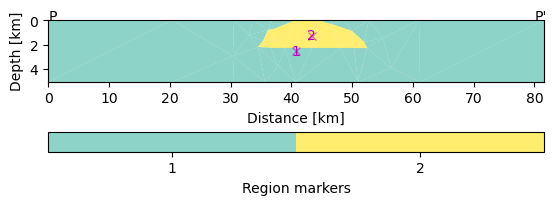

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/589957474.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [116]:
geometry_mag2 = plot_polygons(poly2_mag2,
                              poly1_mag2,
                              coordinates=converted_points_mag2)
fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_ylim(left_mag2,right_mag2)
ax.set_xlim(-depth_mag2,0)
ax.set_xticks(np.arange(0, 50e3, step=5e3), labels=[str(i*10) for i in range(10)])
ax.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax.annotate(text='P',xy=[2,0],zorder=0)
ax.annotate(text='P\'',xy=[40e3,0],zorder=0)
drawMesh(ax,geometry_mag2)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Mag_Model2_2D.pdf')

### Creating a 3D model from it

In [117]:
mag3D_2_norot,mag3D_2,volmag3D_2 = polymaker3D(poly1_mag2,
                      converted_points_mag2,
                      -depth_mag2,
                      0,
                      Ptheta,
                      spacing=100)

z =  -2200.0
Making cylinder
12.518702049910543 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpqpsolcrm.poly.
  Segments are connected properly.
Rotating mesh
z =  -2100.0
Making cylinder
12.183214318794182 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpuijv2zg3.poly.
  Segments are connected properly.
Rotating mesh
z =  -2000.0
Making cylinder
11.85228320614993 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpvoypll_w.poly.
  Segments are connected properly.
Rotating mesh
z =  -1900.0
Making cylinder
11.525908711977827 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpoi8hniuo.poly.
  Segments are connected properly.
Rotating mesh
z =  -1800.0
Making cylinder
11.20409083627784 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmphe6jvsq3.poly.
  Segments are connected properly.
Rotating mesh
z =  -1700.0
Making cylinder
10.821202901651777 km3
Making mes

4.3478260869565215 % Complete
8.695652173913043 % Complete
13.043478260869565 % Complete
17.391304347826086 % Complete
21.73913043478261 % Complete
26.08695652173913 % Complete
30.434782608695656 % Complete
34.78260869565217 % Complete
39.130434782608695 % Complete
43.47826086956522 % Complete
47.82608695652174 % Complete
52.17391304347826 % Complete
56.52173913043478 % Complete
60.86956521739131 % Complete
65.21739130434783 % Complete
69.56521739130434 % Complete
73.91304347826086 % Complete
78.26086956521739 % Complete
82.6086956521739 % Complete
86.95652173913044 % Complete
91.30434782608695 % Complete
95.65217391304348 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


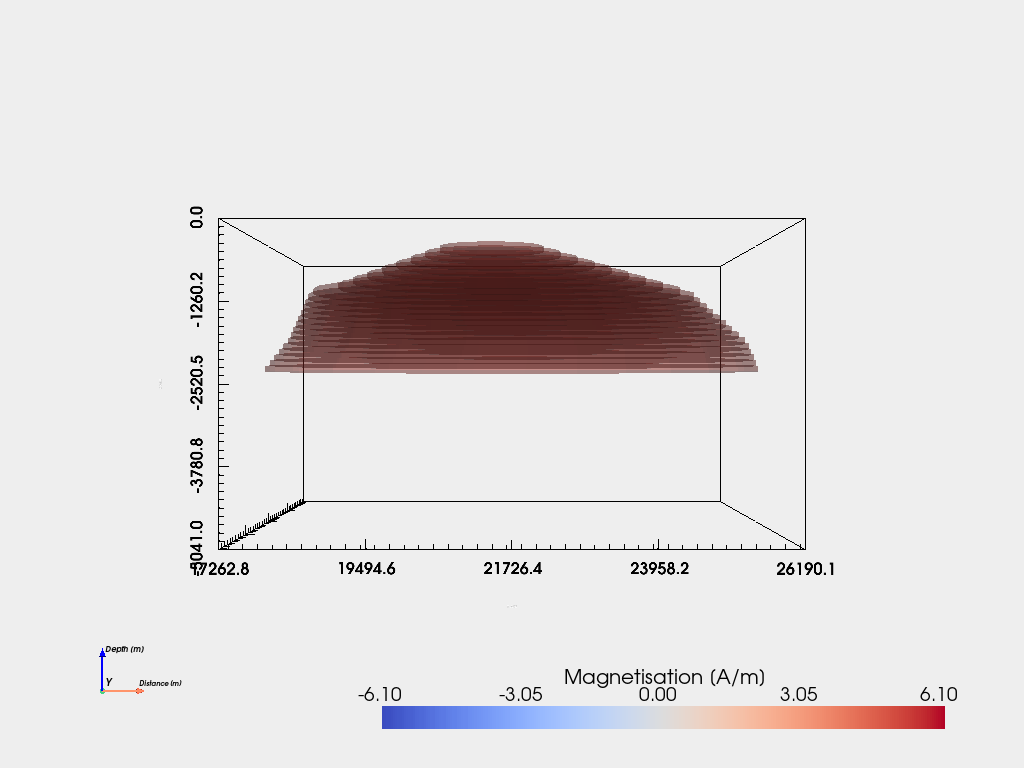

In [118]:
pl,_ = plot3DMagModel(mag3D_2_norot,volmag3D_2,[1,mag2_rho1])
pl.show()
pl.save_graphic('Mag2_Model_3D.pdf')

In [136]:
MagModel2 = MagResponse(mag3D_2,left_mag2,
                                       right_mag2,
                                       500,
                                       Ptheta,
                                       40801, 
                                       70.25, 
                                       -12.074,
                                       mag2_rho1)

03/02/25 - 20:58:49 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 20:58:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 20:58:49 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 112 Cells: 281 Boundaries: 672
03/02/25 - 20:58:49 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.3s x 6): /Users/george/Library/Caches/pygimli/11947112168499440481
03/02/25 - 20:58:49 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 20:58:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 20:58:49 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 116 Cells: 293 Boundaries: 700
03/02/25 - 20:58:49 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.4s x 6): /Users/george/Library/Caches/pygimli/13009720344362386535
03/02/25

In [69]:
np.savetxt('Mag_Model2.txt',MagModel2)

In [137]:
mesh_mag2_2D = mt.createMesh(geometry_mag2, quality=33,smooth=[2,4])
MagAnom2 = pg.solver.parseMapToCellArray([[2, mag2_rho1], [1, mag2_rho2]],mesh_mag2_2D)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(MagModel2[:,0], MagModel2[:,1], "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(MagModel2[:,0], MagModel2[:,2], "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_mag2_2D, MagAnom2, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
#ax[1].plot(x, x*0, 'bv')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag2, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation ($\mathrm{A \ m^{-1}}$)')
fig.tight_layout()
fig.savefig('MagModel2_Response.pdf')

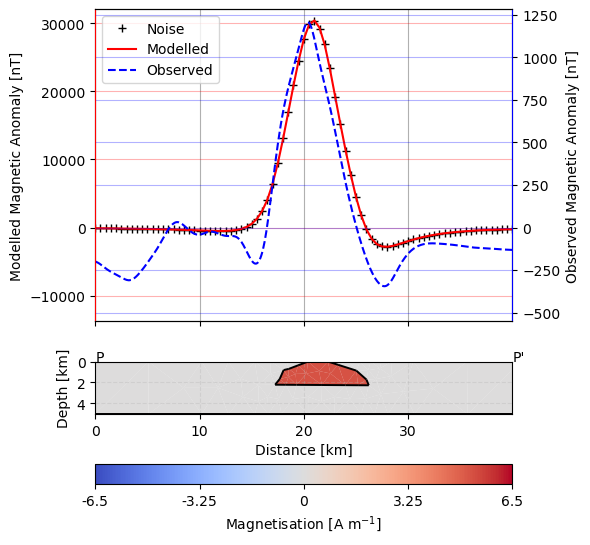

In [138]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(MagModel2[:,0], MagModel2[:,1], "+",c='k', label="Noise")
ln2 = ax[0].plot(MagModel2[:,0], MagModel2[:,2], "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(rtp_profile_array[:,0], rtp_profile_array[:,1], "--",c='b', label="Observed")

mpl_axes_aligner.align.yaxes(ax[0],0,ax2,0,0.3)

ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax2.set_ylabel('Observed Magnetic Anomaly [nT]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_mag2_2D, MagAnom2, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
ax1.grid(alpha=0.3,ls='--')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag1, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation [$\mathrm{A \ m^{-1}}$]')
fig.tight_layout()
fig.savefig('MagModel2_final.pdf')

In [119]:
SSR, SSRn_df = SSR_compare_model(MagModel2,rtp_profile_array)
print(SSR,'\n', SSRn_df)

44.73768066311659 
 0.07700117153720584


## Magnetic Model 3

In [16]:
points_to_convert = np.loadtxt('Model_3_coords_MAG.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([8,9,10,11])
converted_points_mag3 = img_to_coords(points_to_convert,corner_index=corner_indices,depth=5.041e3,width=40.8e3,left_loc=0)

### Setting up the World

In [17]:
left_mag3 = min(converted_points_mag3[:,0])
right_mag3 = max(converted_points_mag3[:,0])
depth_mag3 = max(abs(converted_points_mag3[:,1]))

### Defining each polygon geometry

In [37]:
#adding indices of polygon coordinates in numpy array created above
poly1_mag3 = [0,2,3,4,5,6,7,1]
poly2_mag3 = [8,9,11,10]

#corresponding magnetisations
mag3_rho1 = 6.1
mag3_rho2 = 0

In [38]:
geometry_mag3 = plot_polygons(poly1_mag3,
                              poly2_mag3,
                              coordinates=converted_points_mag3)
fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_ylim(left_mag3,right_mag3)
ax.set_xlim(-depth_mag3,0)
ax.set_xticks(np.arange(0, 50e3, step=5e3), labels=[str(i*10) for i in range(10)])
ax.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax.annotate(text='P',xy=[2,0],zorder=0)
ax.annotate(text='P\'',xy=[40e3,0],zorder=0)
drawMesh(ax,geometry_mag3)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Mag_Model3_2D.pdf')

03/02/25 - 18:51:25 - Core - WARNING - Duplicated node found for: 17190.4	-0	0
03/02/25 - 18:51:25 - Core - WARNING - Duplicated node found for: 0	-0	0


region 1 created!
region 2 created!


/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/2086841851.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


### Extrapolating into 3D

In [39]:
mag3D_3_norot,mag3D_3,volmag3D_3 = polymaker3D(poly1_mag3,
                      converted_points_mag3
                      ,-depth_mag3,
                      0,
                      Ptheta,
                      spacing=100)

z =  -2200.0
Making cylinder
6.386385908890116 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpf7v_p6k7.poly.
  Segments are connected properly.
Rotating mesh
z =  -2100.0
Making cylinder
5.529902188072776 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpi5awluzv.poly.
  Segments are connected properly.
Rotating mesh
z =  -2000.0
Making cylinder
4.735057982472553 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpst9jcizy.poly.
  Segments are connected properly.
Rotating mesh
z =  -1900.0
Making cylinder
4.001853292089432 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpobvaiuj8.poly.
  Segments are connected properly.
Rotating mesh
z =  -1800.0
Making cylinder
3.330288116923409 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpuqrrod4r.poly.
  Segments are connected properly.
Rotating mesh
z =  -1700.0
Making cylinder
2.720362456974497 km3
Making mesh
Op

In [119]:
pl,_ = plot3DMagModel(mag3D_3_norot,volmag3D_3,[1,mag3_rho1])
pl.show()
pl.save_graphic('Mag3_Model_3D.pdf')

4.3478260869565215 % Complete
8.695652173913043 % Complete
13.043478260869565 % Complete
17.391304347826086 % Complete
21.73913043478261 % Complete
26.08695652173913 % Complete
30.434782608695656 % Complete
34.78260869565217 % Complete
39.130434782608695 % Complete
43.47826086956522 % Complete
47.82608695652174 % Complete
52.17391304347826 % Complete
56.52173913043478 % Complete
60.86956521739131 % Complete
65.21739130434783 % Complete
69.56521739130434 % Complete
73.91304347826086 % Complete
78.26086956521739 % Complete
82.6086956521739 % Complete
86.95652173913044 % Complete
91.30434782608695 % Complete
95.65217391304348 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


In [40]:
MagModel3 = MagResponse(mag3D_3,left_mag3,
                                       right_mag3,
                                       500,
                                       Ptheta,
                                       40801, 
                                       70.25, 
                                       -12.074,
                                       mag3_rho1)

03/02/25 - 18:51:32 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 18:51:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 18:51:32 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 76 Cells: 164 Boundaries: 402
03/02/25 - 18:51:32 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.2s x 5): /Users/george/Library/Caches/pygimli/17116473319439408863
03/02/25 - 18:51:32 - pyGIMLi - INFO - Found 1 regions.
03/02/25 - 18:51:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 18:51:33 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 72 Cells: 146 Boundaries: 362
03/02/25 - 18:51:33 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (0.2s x 5): /Users/george/Library/Caches/pygimli/17163672061342972475
03/02/25 -

In [80]:
np.savetxt('Mag_Model3.txt',MagModel3)

In [139]:
mesh_mag3_2D = mt.createMesh(geometry_mag3, quality=33,smooth=[2,4])
MagAnom3 = pg.solver.parseMapToCellArray([[1, mag3_rho1], [2, mag3_rho2]],mesh_mag3_2D)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ax[0].plot(MagModel3[:,0], MagModel3[:,1], "+",c='k', label="Anomaly with Gaussian Noise")
ax[0].plot(MagModel3[:,0], MagModel3[:,2], "-",c='r', label="Noise Free Anomaly")
ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax[0].grid()
ax[0].legend()

ax1,cb1 = pg.show(mesh_mag3_2D, MagAnom3, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag3, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation ($\mathrm{A \ m^{-1}}$)')
fig.tight_layout()
fig.savefig('MagModel3_Response.pdf')

In [140]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln1 = ax[0].plot(MagModel3[:,0], MagModel3[:,1], "+",c='k', label="Noise")
ln2 = ax[0].plot(MagModel3[:,0], MagModel3[:,2], "-",c='r', label="Modelled")

ax2 = ax[0].twinx()

ln3 = ax2.plot(rtp_profile_array[:,0], rtp_profile_array[:,1], "--",c='b', label="Observed")

mpl_axes_aligner.align.yaxes(ax[0],0,ax2,0,0.3)

ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax2.set_ylabel('Observed Magnetic Anomaly [nT]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_mag3_2D, MagAnom3, ax=ax[1],cMap='coolwarm',cMin=-6.5,cMax=6.5)
#ax[1].plot(x, x*0, 'bv')
ax1.grid(alpha=0.3,ls='--')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_mag1, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=10e3), labels=[str(i*10) for i in range(4)])
ax1.set_yticks(np.arange(0, -6e3, step=-2e3), labels=[str(i*2) for i in range(3)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation [$\mathrm{A \ m^{-1}}$]')
fig.tight_layout()
fig.savefig('MagModel3_final.pdf')

In [120]:
SSR, SSRn_df = SSR_compare_model(MagModel3,rtp_profile_array)
print(SSR,'\n', SSRn_df)

36.899133829331916 
 0.06350969678026147


## Modelling all three centres (magnetic)

In [18]:
points_to_convert = np.loadtxt('MagCombo.csv',delimiter=',',usecols = (1,2))
corner_indices = np.array([0,3,1,2])
converted_points_magC = img_to_coords(points_to_convert,corner_index=corner_indices,depth=13.94e3,width=37.4e3,left_loc=17.44e3)
loc_diff = converted_points_mag3[0][0]-converted_points_magC[15][0] # calculating the change in location needed for this model
converted_points_magC[:,0]=converted_points_magC[:,0]+loc_diff


### Setting up the World

In [19]:
left_magC = min(converted_points_magC[:,0])
right_magC = max(converted_points_magC[:,0])
depth_magC = max(abs(converted_points_magC[:,1]))

### Defining each polygon geometry

In [20]:
#adding indices of polygon coordinates in numpy array created above
poly1_magC = [21,20,22,23,25,24,4,8,26,15] # main body
poly2_magC = [4,5,6,7,12,8] # centre 1
poly3_magC = [15,16,14,13,9,6,10,11,12,8,26] # centre 2
poly4_magC = [21,15,27,16,17,18,19,20] # centre 3

#corresponding magnetisations
magC_rho1 = 0.5 # main body
magC_rho2 = -0.5 # centre 1
magC_rho3 = 6.1 # centre 2
magC_rho4 = -0.5 # centre 3

03/02/25 - 18:02:14 - Core - WARNING - Duplicated node found for: 9774.88	-0	0
03/02/25 - 18:02:14 - Core - WARNING - Duplicated node found for: 28889.4	-298.059	0


03/02/25 - 18:02:14 - Core - WARNING - Duplicated node found for: 17190.4	-0	0
03/02/25 - 18:02:14 - Core - WARNING - Duplicated node found for: 9774.88	-0	0


region 1 created!
region 2 created!
region 3 created!
region 4 created!


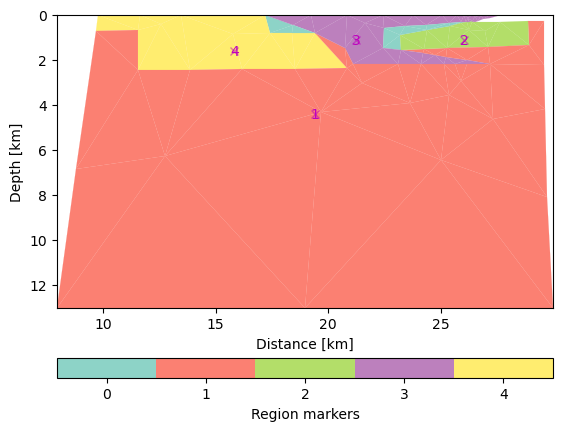

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_77135/1647014248.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [21]:
geometry_magC = plot_polygons(poly1_magC,
                              poly2_magC,
                              poly3_magC,
                              poly4_magC,
                              coordinates=converted_points_magC)
fig,ax = pg.plt.subplots()
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Distance [km]')
ax.set_ylim(left_magC,right_magC)
ax.set_xlim(-depth_magC,0)
ax.set_xticks(np.arange(0, 60e3, step=5e3), labels=[str(i*5) for i in range(12)])
ax.set_yticks(np.arange(0, -16e3, step=-2e3), labels=[str(i*2) for i in range(8)])
ax.annotate(text='P',xy=[2,0],zorder=0)
ax.annotate(text='P\'',xy=[40e3,0],zorder=0)
drawMesh(ax,geometry_magC)
pg.wait()
fig.tight_layout()
fig.show()
fig.savefig('Mag_ModelC_2D.pdf')

### Extrapolating into 3D

In [22]:
mag3D_C_norot1,mag3D_C_1,volmag3D_C_1 = polymaker3D(poly1_magC,
                      converted_points_magC
                      ,-depth_magC,
                      0,
                      Ptheta,
                      spacing=500,
                      marker=1)

z =  -13000.0
Making cylinder
381.33593106880403 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp5p_ul9nz.poly.
  Segments are connected properly.
Rotating mesh
z =  -12500.0
Making cylinder
377.9454899946366 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp5emyrasl.poly.
  Segments are connected properly.
Rotating mesh
z =  -12000.0
Making cylinder
374.5701884295628 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmphkc13jid.poly.
  Segments are connected properly.
Rotating mesh
z =  -11500.0
Making cylinder
371.21002637358214 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpaltrjpmq.poly.
  Segments are connected properly.
Rotating mesh
z =  -11000.0
Making cylinder
367.8650038266948 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp16dd1gvq.poly.
  Segments are connected properly.
Rotating mesh
z =  -10500.0
Making cylinder
364.53512078890094 km3
Makin

3.7037037037037033 % Complete
7.4074074074074066 % Complete
11.11111111111111 % Complete
14.814814814814813 % Complete
18.51851851851852 % Complete
22.22222222222222 % Complete
25.925925925925924 % Complete
29.629629629629626 % Complete
33.33333333333333 % Complete
37.03703703703704 % Complete
40.74074074074074 % Complete
44.44444444444444 % Complete
48.148148148148145 % Complete
51.85185185185185 % Complete
55.55555555555556 % Complete
59.25925925925925 % Complete
62.96296296296296 % Complete
66.66666666666666 % Complete
70.37037037037037 % Complete
74.07407407407408 % Complete
77.77777777777779 % Complete
81.48148148148148 % Complete
85.18518518518519 % Complete
88.88888888888889 % Complete
92.5925925925926 % Complete
96.29629629629629 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


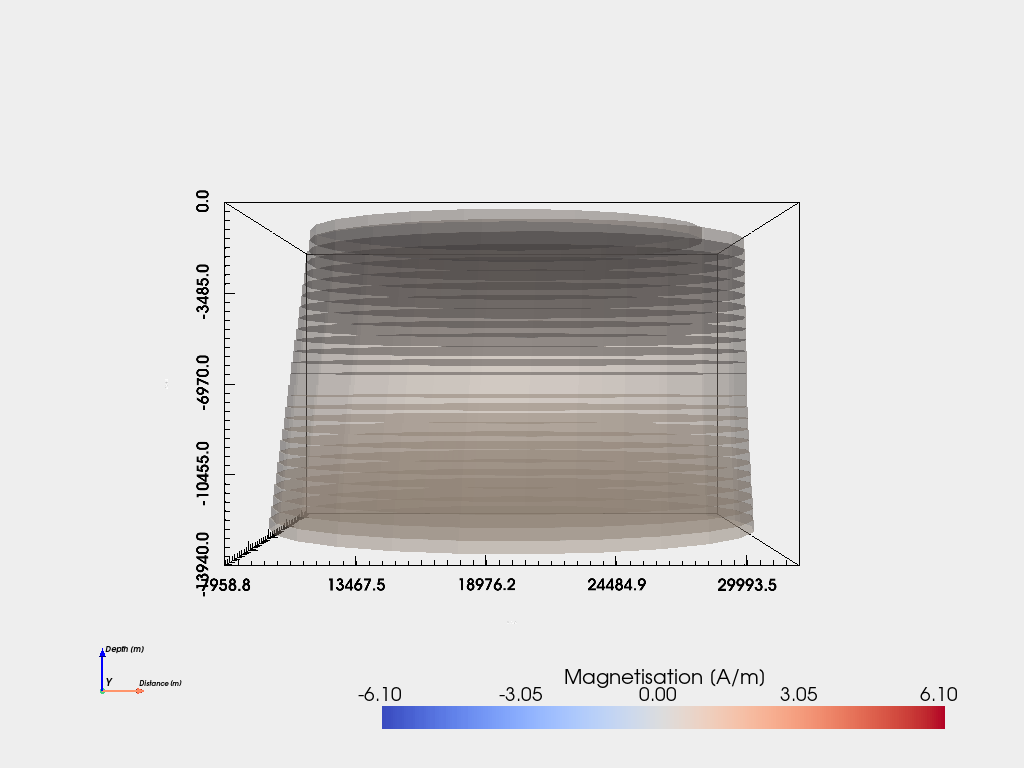

In [120]:
pl,_ = plot3DMagModel(mag3D_C_norot1,volmag3D_C_1,[1,magC_rho1])
pl.show()
pl.save_graphic('MagC_Model_3D_1.pdf')

In [23]:
mag3D_C_norot2,mag3D_C_2,volmag3D_C_2 = polymaker3D(poly2_magC,
                      converted_points_magC
                      ,-3485,
                      0,
                      Ptheta,
                      spacing=100,
                      marker=2
                      )

z =  -1500.0
Making cylinder
0.42211195741928975 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpbp2xcc80.poly.
  Segments are connected properly.
Rotating mesh
z =  -1400.0
Making cylinder
3.0604661089606835 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpeg7ardhj.poly.
  Segments are connected properly.
Rotating mesh
z =  -1300.0
Making cylinder
5.151934434775111 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpmzmv0uw4.poly.
  Segments are connected properly.
Rotating mesh
z =  -1200.0
Making cylinder
5.156541470986841 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpa3yypyyx.poly.
  Segments are connected properly.
Rotating mesh
z =  -1100.0
Making cylinder
5.161150566162849 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp63rsjf1j.poly.
  Segments are connected properly.
Rotating mesh
z =  -1000.0
Making cylinder
5.165761720303143 km3
Making mesh

In [121]:
pl,_ = plot3DMagModel(mag3D_C_norot2,volmag3D_C_2,[2,magC_rho2])
pl.show()
pl.save_graphic('MagC_Model_3D_2.pdf')

7.6923076923076925 % Complete
15.384615384615385 % Complete
23.076923076923077 % Complete
30.76923076923077 % Complete
38.46153846153847 % Complete
46.15384615384615 % Complete
53.84615384615385 % Complete
61.53846153846154 % Complete
69.23076923076923 % Complete
76.92307692307693 % Complete
84.61538461538461 % Complete
92.3076923076923 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


In [122]:
mag3D_C_norot3,mag3D_C_3,volmag3D_C_3 = polymaker3D(poly3_magC,
                      converted_points_magC
                      ,-3485,
                      0,
                      Ptheta,
                      spacing=100,
                      marker=3)

z =  -2200.0
Making cylinder
0.011675722501970314 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmprgxb1kkm.poly.
  Segments are connected properly.
Rotating mesh
z =  -2100.0
Making cylinder
4.748451476425129 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpr4jiedm3.poly.
  Segments are connected properly.
Rotating mesh
z =  -2000.0
Making cylinder
3.825083448869544 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmprjf34qlo.poly.
  Segments are connected properly.
Rotating mesh
z =  -1900.0
Making cylinder
3.001452037530754 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpk9wy2651.poly.
  Segments are connected properly.
Rotating mesh
z =  -1800.0
Making cylinder
2.277557242408775 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpwvohhnqg.poly.
  Segments are connected properly.
Rotating mesh
z =  -1700.0
Making cylinder
1.6533990635035989 km3
Making mes

In [123]:
pl,_ = plot3DMagModel(mag3D_C_norot3,volmag3D_C_3,[3,magC_rho3])
pl.show()
pl.save_graphic('MagC_Model_3D_3.pdf')

4.3478260869565215 % Complete
8.695652173913043 % Complete
13.043478260869565 % Complete
17.391304347826086 % Complete
21.73913043478261 % Complete
26.08695652173913 % Complete
30.434782608695656 % Complete
34.78260869565217 % Complete
39.130434782608695 % Complete
43.47826086956522 % Complete
47.82608695652174 % Complete
52.17391304347826 % Complete
56.52173913043478 % Complete
60.86956521739131 % Complete
65.21739130434783 % Complete
69.56521739130434 % Complete
73.91304347826086 % Complete
78.26086956521739 % Complete
82.6086956521739 % Complete
86.95652173913044 % Complete
91.30434782608695 % Complete
95.65217391304348 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


In [25]:
mag3D_C_norot4,mag3D_C_4,volmag3D_C_4 = polymaker3D(poly4_magC,
                      converted_points_magC
                      ,-3485,
                      0,
                      Ptheta,
                      spacing=100,
                      marker=4,
                      )

z =  -2400.0
Making cylinder
9.334338773781957 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp54qia19s.poly.
  Segments are connected properly.
Rotating mesh
z =  -2300.0
Making cylinder
13.299002921520458 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp92bjihxl.poly.
  Segments are connected properly.
Rotating mesh
z =  -2200.0
Making cylinder
13.031948531161849 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmpan5u7wyp.poly.
  Segments are connected properly.
Rotating mesh
z =  -2100.0
Making cylinder
12.767602735730385 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp5hcgvh76.poly.
  Segments are connected properly.
Rotating mesh
z =  -2000.0
Making cylinder
12.505965535226048 km3
Making mesh
Opening /var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/tmp4orvhf0n.poly.
  Segments are connected properly.
Rotating mesh
z =  -1900.0
Making cylinder
12.247036929648857 km3
Making me

In [124]:
pl,_ = plot3DMagModel(mag3D_C_norot4,volmag3D_C_4,[4,magC_rho4])
pl.show()
pl.save_graphic('MagC_Model_3D_4.pdf')

4.0 % Complete
8.0 % Complete
12.0 % Complete
16.0 % Complete
20.0 % Complete
24.0 % Complete
28.000000000000004 % Complete
32.0 % Complete
36.0 % Complete
40.0 % Complete
44.0 % Complete
48.0 % Complete
52.0 % Complete
56.00000000000001 % Complete
60.0 % Complete
64.0 % Complete
68.0 % Complete
72.0 % Complete
76.0 % Complete
80.0 % Complete
84.0 % Complete
88.0 % Complete
92.0 % Complete
96.0 % Complete
100.0 % Complete


/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


### Merge each body, followed by each body with the the largest body

In [26]:
mesh1 = mt.mergeMeshes(mag3D_C_1)
mesh2 = mt.mergeMeshes(mag3D_C_2)
mesh3 = mt.mergeMeshes(mag3D_C_3)
mesh4 = mt.mergeMeshes(mag3D_C_4)

In [27]:
BodyC1 = mt.merge2Meshes(mesh1,mesh2)
BodyC12 = mt.merge2Meshes(BodyC1,mesh3)
BodyC123 = mt.merge2Meshes(BodyC12,mesh4)

In [28]:
def MagResponseMulti(mesh,left,right,spacing,angle,F,I,D,Mags,cmp=['TFA']):
    """
    meshes : list of pyGIMLi meshes
        List of meshes to have response calculated
    left : float
        Minimum x value of world (where magnetic response will be taken)
    right : float
        Maximum x value of world (where magnetic response will be taken)
    spacing : float
        Spacing of points to measure magnetic response (in metres)
    angle : float
        Angle (in radians) which the mesh was rotated
    F : float
        the value of the total magnetic field anomaly in nT
    I : float
        inclination
    D : float
        declination
    Mags : list
        List of marker numbers and magnetisations (in nT)
    cmp : string
        Forward operator (default: ['TFA'])
    """
    igrf = igrf_calc(F, I, D)

    x = np.arange(left,right,spacing)
    y = np.zeros(len(x))
    z = np.ones_like(x)*1.5e3

    points_mag2D_1 = list(map(lambda a, b:(a,b), x, y))

    rot_points_mag2D_1 = rotate(points_mag2D_1,angle=angle)

    final_points_mag2D_1 = np.column_stack((rot_points_mag2D_1[:,0],rot_points_mag2D_1[:,1],z))

    fop = MagneticsModelling(mesh=mesh, points=final_points_mag2D_1,cmp=cmp,igrf=igrf)

    dRho_mag13D = pg.solver.parseMapToCellArray(Mags,mesh=mesh)

    mag3D_1_rep = fop.response(dRho_mag13D)

    noise_level = np.abs(mag3D_1_rep)*0.02+1
    data_mag3D_1 = (np.random.randn(len(mag3D_1_rep)) * noise_level)+mag3D_1_rep

    ###
    MagModel = np.column_stack((x,data_mag3D_1,mag3D_1_rep))

    return MagModel

In [145]:
mags1 = [0.3,0.1,0,-0.1,-0.3] # unknown polarity underlying centre 
mags2 = [0,-0.3,-0.5,-0.7,-0.9,-1.1,-1.3,-1.5,-1.7,-1.9,2.1] # reverse polarity centre 1
mags3 = [0,0.3,0.5,0.7,0.9,1.1] # normal polarity centre 3

#create combinations to explore
parameter_sets = [
    dict(R1=combo[0],R2=combo[1],R3=combo[2])
    for combo in itertools.product(mags1, mags2, mags3)
]
print(len(parameter_sets))

330


In [146]:
SSRn_dfs = []
SSRs = []
R1 = []
R2 = []
R3 = []
for param in parameter_sets:
    Mags = [[1, param["R1"]],[2, param["R2"]],[3, magC_rho3],[4, param["R3"]]]
    Response = MagResponseMulti(BodyC123,left_magC,
                                       right_magC,
                                       500,
                                       Ptheta,
                                       40801, 
                                       70.25, 
                                       -12.074,
                                       Mags = Mags)

    SSR, SSRn_df = SSR_compare_model(Response,rtp_profile_array)
    SSRn_dfs.append(SSRn_df)
    SSRs.append(SSR)
    R1.append(param["R1"])
    R2.append(param["R2"])
    R3.append(param["R3"])
final = np.column_stack((R1,R2,R3,SSRs,SSRn_dfs))
np.savetxt('MagModelC_outputs4.txt',final)

03/02/25 - 22:18:12 - pyGIMLi - INFO - Found 4 regions.
03/02/25 - 22:18:12 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
03/02/25 - 22:18:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 22:18:17 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 13868 Cells: 37467 Boundaries: 88613
03/02/25 - 22:18:20 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (48.8s x 1556): /Users/george/Library/Caches/pygimli/17922489402205331815
03/02/25 - 22:18:23 - pyGIMLi - INFO - Found 4 regions.
03/02/25 - 22:18:23 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
03/02/25 - 22:18:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/02/25 - 22:18:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 13868 Cells: 37467 Boundaries: 88613
03/02/25 - 22:18:29 - pyGIMLi - INFO - Cache /usr/loca

In [147]:
index = np.where(SSRn_dfs==np.min(SSRn_dfs))[0][0]
print('R1: ',R1[index])
print('R2: ',R2[index])
print('R3: ',R3[index])
print('SSRn_df: ',SSRn_dfs[index],'\n','SSR: ',SSRs[index])

R1:  0.1
R2:  -1.9
R3:  0
SSRn_df:  0.04987144020895704 
 SSR:  28.6760781201503


In [153]:
Mags = [[1, 0.1],[2, -1.9],[3, magC_rho3],[4, 0]]
MagModelC_final = MagResponseMulti(BodyC123,left_magC,
                                       right_magC,
                                       500,
                                       Ptheta,
                                       40801, 
                                       70.25, 
                                       -12.074,
                                       Mags = Mags)

04/02/25 - 08:20:12 - pyGIMLi - INFO - Found 4 regions.
04/02/25 - 08:20:12 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
04/02/25 - 08:20:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/02/25 - 08:20:17 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 13868 Cells: 37467 Boundaries: 88613
04/02/25 - 08:20:20 - pyGIMLi - INFO - Cache /usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pygimli/physics/gravimetry/kernel.py:SolveGravMagHolstein restored (48.8s x 1889): /Users/george/Library/Caches/pygimli/17922489402205331815


In [154]:
np.savetxt('Mag_ModelC.txt',MagModelC_final)

In [155]:
SSR, SSRn_df = SSR_compare_model(MagModelC_final,rtp_profile_array)
print(SSR,'\n', SSRn_df)

28.6760781201503 
 0.04987144020895704


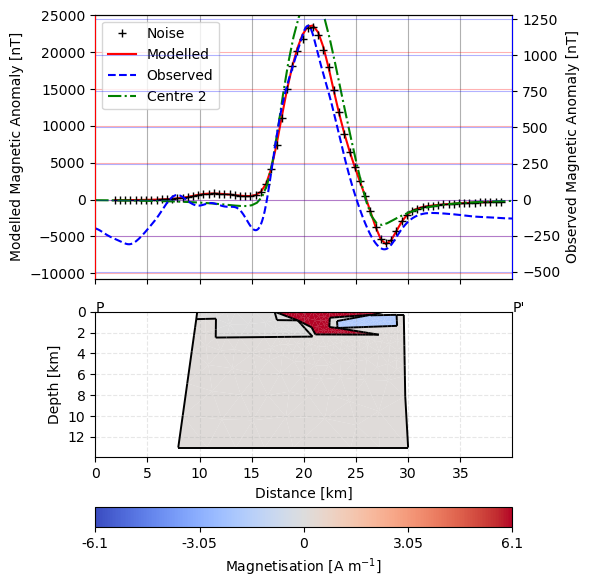

In [156]:
mesh_magC_2D = mt.createMesh(geometry_magC, quality=33,smooth=[2,4])
MagAnomC_final = pg.solver.parseMapToCellArray(Mags,mesh_magC_2D)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True,figsize=(6,6))
ln2 = ax[0].plot(MagModelC_final[:,0], MagModelC_final[:,2], "-", label="Modelled",c='r')
ln1 = ax[0].plot(MagModelC_final[:,0], MagModelC_final[:,1], "+", label="Noise",c='k')

ax2 = ax[0].twinx()

ln3 = ax2.plot(rtp_profile_array[:,0], rtp_profile_array[:,1], "--",c='b', label="Observed")

mpl_axes_aligner.align.yaxes(ax[0],0,ax2,0,0.3) # scale the axes

ln4 = ax[0].plot(MagModel3[:,0],MagModel3[:,2],"-.",label="Centre 2",c='g')

ax[0].set_ylabel('Modelled Magnetic Anomaly [nT]')
ax2.set_ylabel('Observed Magnetic Anomaly [nT]')

ax[0].grid(axis='x')
ax[0].grid(axis='y',c='r',alpha=0.3)
ax2.grid(axis='y',c='b',alpha=0.3)

ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=2)

ax1,cb1 = pg.show(mesh_magC_2D, MagAnomC_final, ax=ax[1],cMap='coolwarm',cMin=-6.1,cMax=6.1)
ax1.grid(alpha=0.3,ls='--')
ax1.set_ylabel('Depth [km]')
ax1.set_xlabel('Distance [km]')
ax1.set_ylim((-depth_magC, 1))
ax1.set_xlim((0, 40e3))
ax1.set_xticks(np.arange(0, 40e3, step=5e3), labels=[str(i*5) for i in range(8)])
ax1.set_yticks(np.arange(0, -14e3, step=-2e3), labels=[str(i*2) for i in range(7)])
ax1.annotate(text='P',xy=[2,0],zorder=0)
ax1.annotate(text='P\'',xy=[40e3,0],zorder=0)

cb1.set_label(r'Magnetisation [$\mathrm{A \ m^{-1}}$]')
fig.tight_layout()
fig.savefig('MagModelC_final1.pdf')

In [157]:
pl, _ = pg.show(BodyC1,style='wireframe',
                opacity=0, hold=True)

Amag = pg.solver.parseMapToCellArray(Mags,BodyC123)
pvmesh = pg.viewer.pv.toPVMesh(mesh=BodyC123,data=Amag,label='Magnetisation [A/m]')
pl.add_mesh(pvmesh,opacity=0.3,style='surface',cmap='coolwarm', clim=[-6.1,6.1])
pl.add_axes(interactive=False,xlabel='Distance [m]',zlabel='Depth [m]')
pl.zoom_camera(10)
pl.camera_position = 'xz'
pl.show()
pl.save_graphic('MagC_Model_3D_final.pdf')

/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/usr/local/Caskroom/miniforge/base/envs/pg/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
